In [1]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [3]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from torch.cuda import amp
from transformers import AutoModel, AutoTokenizer,AutoConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import torch
import warnings
from sklearn.model_selection import StratifiedKFold
import random
warnings.filterwarnings('ignore')
from collections import defaultdict
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
import gc
gc.enable()

In [4]:
splits = {'train': 'cleaned_train_multi.csv', 'test': 'cleaned_test_multi.csv'}
train_df = pd.read_csv("hf://datasets/kcrl/Shared_Task_Fake_News_Multi/" + splits["train"])
test_df = pd.read_csv("hf://datasets/kcrl/Shared_Task_Fake_News_Multi/" + splits["test"])

In [22]:
labeling = {
    'False': 0,
    'HALF TRUE':1,
    'MOSTLY FALSE':2,
    'PARTLY FALSE':3
}
test_df['Label'] = test_df['Label'].apply(lambda x : labeling[x])

In [6]:
class Config:
    NUM_EPOCHS = 10
    NUM_FOLDS = 7
    BATCH_SIZE = 32
    MODEL_PATH = "FacebookAI/xlm-roberta-base"
    LR = 2e-5
    DROPOUT = 0.3
    NUM_CLASSES = 4
    SEED = 42
    MAX_LEN = 80
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [7]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [8]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["News"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }

In [9]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel,self).__init__()
        self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
        self.model = AutoModel.from_pretrained(config.MODEL_PATH,config = self.model_config)
        # Adjusting input size for three pooling methods
        self.dense = torch.nn.Linear(self.model_config.hidden_size * 3, self.model_config.hidden_size)
        self.dropout = torch.nn.Dropout(config.DROPOUT)
        self.classifier = nn.Linear(self.model_config.hidden_size, config.NUM_CLASSES)
        
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids,attention_mask=attention_mask)
        last_hidden_state = output[0]
        
        # CLS token
        cls_token = last_hidden_state[:,0,:]
        
        # Mean pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        
        # Max pooling
        last_hidden_state[input_mask_expanded == 0] = -1e9 
        max_embeddings = torch.max(last_hidden_state, 1)[0]
        
        # Concatenate all three embeddings
        pooled = torch.cat((cls_token, mean_embeddings, max_embeddings), 1)
        pooler = self.dense(pooled)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)
            # Get predictions
            outputs = model(input_ids, attention_mask)
            
            # Apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)
            
            predictions.append(probs.to("cpu").numpy())
    
    return np.concatenate(predictions)

In [12]:
test_dataset = ClassifierDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, 
                        batch_size=64, 
                        drop_last=False,
                        collate_fn=data_collator, 
                        shuffle=False, 
                        num_workers=2)

total_samples = len(test_dataset)  
print(f"Initializing array for {total_samples} samples")

Initializing array for 200 samples


In [ ]:
num_classes = 4  
all_predictions = np.zeros((config.NUM_FOLDS, total_samples, num_classes))

for fold in range(config.NUM_FOLDS):            
    model_path = f"/kaggle/input/fake-news-multi-xlm-r-cls-mean-max/model_{fold}.bin"
    print(f"\nUsing {model_path}")
                        
    model = ClassifierModel()
    model.load_state_dict(torch.load(model_path))    
    model.to(config.DEVICE)
    
    # Get predictions for current fold
    fold_predictions = predict(model, test_loader)
    
    # Double check shapes before assignment
    print(f"all_predictions shape: {all_predictions.shape}")
    print(f"fold_predictions shape: {fold_predictions.shape}")
    
    assert fold_predictions.shape == (total_samples, num_classes), \
           f"Prediction shape mismatch: got {fold_predictions.shape}, expected ({total_samples}, {num_classes})"
    
    # Store predictions for this fold
    all_predictions[fold] = fold_predictions
    
    # Free up memory
    del model
    gc.collect()

# Calculate mean probabilities across all folds
final_probabilities = all_predictions.mean(axis=0)

# Get final class predictions from probabilities
final_predictions = np.argmax(final_probabilities, axis=1)


Using /kaggle/input/fake-news-multi-xlm-r-cls-mean-max/model_0.bin


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

all_predictions shape: (7, 200, 4)
fold_predictions shape: (200, 4)

Using /kaggle/input/fake-news-multi-xlm-r-cls-mean-max/model_1.bin
all_predictions shape: (7, 200, 4)
fold_predictions shape: (200, 4)

Using /kaggle/input/fake-news-multi-xlm-r-cls-mean-max/model_2.bin
all_predictions shape: (7, 200, 4)
fold_predictions shape: (200, 4)

Using /kaggle/input/fake-news-multi-xlm-r-cls-mean-max/model_3.bin
all_predictions shape: (7, 200, 4)
fold_predictions shape: (200, 4)

Using /kaggle/input/fake-news-multi-xlm-r-cls-mean-max/model_4.bin
all_predictions shape: (7, 200, 4)
fold_predictions shape: (200, 4)

Using /kaggle/input/fake-news-multi-xlm-r-cls-mean-max/model_5.bin
all_predictions shape: (7, 200, 4)
fold_predictions shape: (200, 4)

Using /kaggle/input/fake-news-multi-xlm-r-cls-mean-max/model_6.bin
all_predictions shape: (7, 200, 4)
fold_predictions shape: (200, 4)


In [14]:
len(final_predictions)

200

In [23]:
y_true = test_df['Label'].values

In [24]:
y_pred = final_predictions

In [25]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Print the classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Calculate individual metrics for weighted and macro averages
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_f1 = f1_score(y_true, y_pred, average='macro')

weighted_precision = precision_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')

weighted_recall = recall_score(y_true, y_pred, average='weighted')
macro_recall = recall_score(y_true, y_pred, average='macro')

accuracy = accuracy_score(y_true, y_pred)

# Print metrics
print("Weighted F1 Score:", weighted_f1)
print("Macro F1 Score:", macro_f1)
print("Weighted Precision:", weighted_precision)
print("Macro Precision:", macro_precision)
print("Weighted Recall:", weighted_recall)
print("Macro Recall:", macro_recall)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.79       100
           1       0.65      0.41      0.50        37
           2       0.55      0.57      0.56        56
           3       0.80      0.57      0.67         7

    accuracy                           0.68       200
   macro avg       0.69      0.60      0.63       200
weighted avg       0.67      0.68      0.67       200

Confusion Matrix:
 [[84  0 15  1]
 [12 15 10  0]
 [16  8 32  0]
 [ 2  0  1  4]]
Weighted F1 Score: 0.665549680275455
Macro F1 Score: 0.6282792261026398
Weighted Precision: 0.671555985165312
Macro Precision: 0.6851850390594176
Weighted Recall: 0.675
Macro Recall: 0.5970656370656371
Accuracy: 0.675


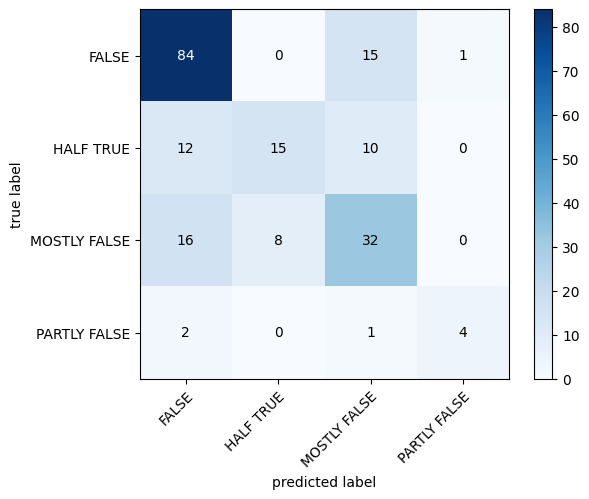

In [26]:
import torch
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
y_pred = torch.tensor(y_pred)
y_true = torch.tensor(y_true)

cmat = ConfusionMatrix(task="MULTICLASS", num_classes=4)
confusion_matrix = cmat(y_pred, y_true)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
                                class_names=['FALSE','HALF TRUE','MOSTLY FALSE','PARTLY FALSE'],
                                colorbar=True)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()